# Project 4: West Nile Virus Prediction

____________

# Part 1a - Train Data EDA & Cleaning

### Group 4, SG-DSI-18

In this notebook, we will be cleaning and analyzing the train data.

Train dataset includes information on the mosquito traps such as location, tests for Wnv presence, etc.

## Problem Statement

West Nile Virus (Wnv), a mosquito-bourne arbovirus, has been causing significant and sometimes severe human diseases. Although pesticides are known to be effective in dealing with the virus-carrying mosquitoes, it is expensive to deploy pesticides throughout the city. As data scientists in the Division of Societal Cures in Epidemiology & New Creative Engineering, we want to understand the factors driving the spread of Wnv by leveraging on data collected by Chicago's weather stations and the surveillance system set up by the Chicago Department of Public Health. We also want to develop a classfication model that could predict the presence of Wnv within the area of Windy City. Through these studies, we hope to suggest a cost-efficient and effective method of deploying pesticides within the area.

### Contents:
- [EDA & Cleaning](#EDA-&-Cleaning)

### Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import geopy.distance
import folium
from branca.element import Figure
from folium.plugins import MarkerCluster

In [2]:
#Importing of dataset
url = '../datasets/train.csv'

In [3]:
train = pd.read_csv(url)

## EDA & Cleaning

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [5]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [6]:
train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


In [7]:
train.shape

(10506, 12)

In [8]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

### Location Features

We shall look at the location features. 

In [9]:
location = train[['Address','Block','Street','AddressNumberAndStreet','Latitude','Longitude']]

In [10]:
location.head()

,Address,Block,Street,AddressNumberAndStreet,Latitude,Longitude
0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991
1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991
2,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279
3,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812
4,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812


As the latitude and longitude defines the locations, we will be dropping the rest of the features.

In [11]:
#As we will be using lat and long for location, the following features will be removed.
train.drop(columns=['Address','Block','Street','AddressNumberAndStreet'],inplace=True)

### West Nile Virus and the Mosquitoes

Let's study the virus and its relation to the mosquitoes in this section.

Firstly, let's study the number of mosquitoes in terms of timing.

In [12]:
# Make Date into datetime
train['Date'] = pd.to_datetime(train['Date'])

# Add week and Year columns
train['Week'] = (train['Date'].dt.strftime('%W')).astype(int)
train['Year'] = (train['Date'].dt.strftime('%Y')).astype(int)

Text(0, 0.5, 'Number of mosquitos')

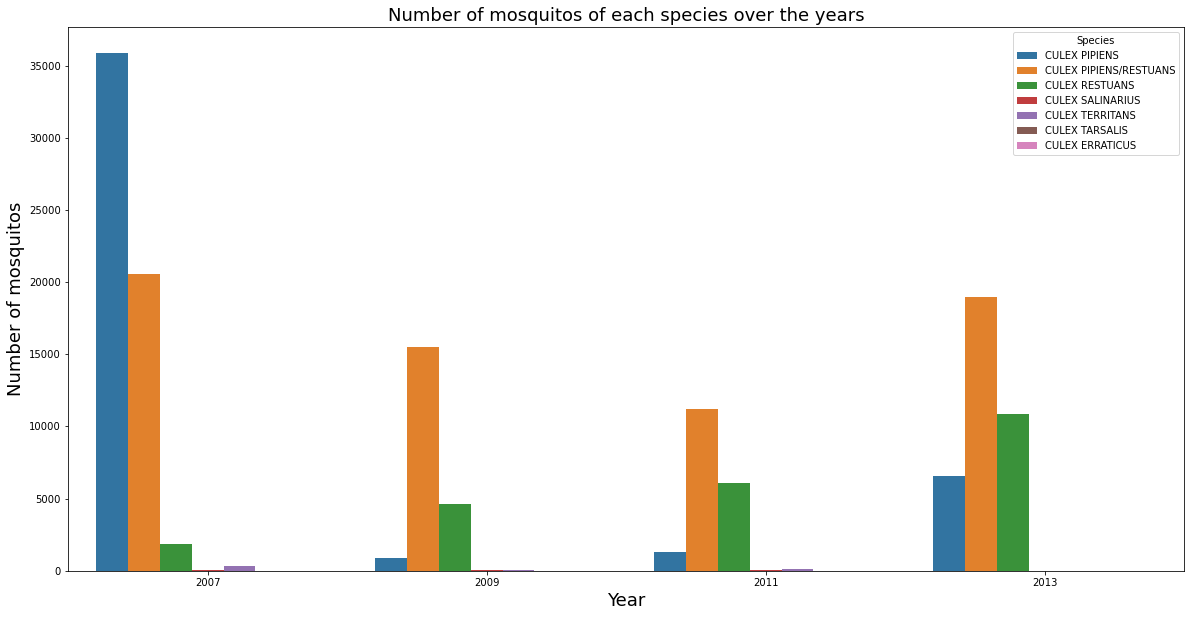

In [13]:
#Number of mosquitos per year and per species
year_mozzie = train.groupby(['Year','Species'], as_index=False).sum().reindex()

plt.figure(figsize=(20,10))
sns.barplot(x='Year',y='NumMosquitos',hue='Species',data= year_mozzie)
plt.title('Number of mosquitos of each species over the years',fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Number of mosquitos', fontsize=18)

Above plot indicates the number of mosquitoes for each species for each year. 

Not all mosquitoes species carry West Nile Virus. We will sort out those that carry the virus.

In [14]:
#Not all species contain WNV. Below sorting out species with WNV
wnv_species = train.loc[train['WnvPresent'] == 1,['Species']]

After sorting, there are only two species which carry the virus, which are Culex Pipiens and Culex Restuans.

In [15]:
wnv_species['Species'].value_counts()

CULEX PIPIENS/RESTUANS    262
CULEX PIPIENS             240
CULEX RESTUANS             49
Name: Species, dtype: int64

Text(0.5, 1.0, 'Mosquitoes Species with West Nile Virus')

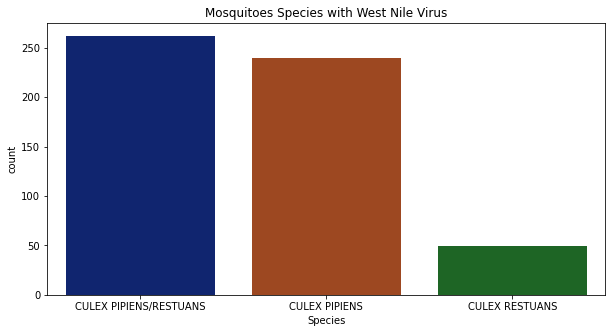

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'Species',data = wnv_species,palette='dark')
plt.title('Mosquitoes Species with West Nile Virus')

Based on the table above, most of the mosquitoes with the virus are pipiens or restuans.

Next we will clean the number of mosquitoes feature. Apparently, the data provided are organized in such a way that when the number of mosquitoes exceed 50, it will be split into another record which is another row in the dataset. Therefore, we will be summing them up.

In this section, we will be mapping the mosquitoes species feature to values pertaining to the following:
* culex pipiens/restuans
* culex pipiens
* culex restuans
* other species  

This is because that the first three species are the mosquitoes with the virus. The rest of the species which do not have the virus will be put together in other species and will mapped as 0. Culex pipiens/restuans and culex pipiens will have a value 2 as they have similar competencies in carrying the Wnv as shown above. Culex restuans will have a value 1.

In [17]:
#Looking for records that are wnvpresent and have num of mosquitos over 50.
wnv_present = train[train['WnvPresent'] == 1]
wnv_present[wnv_present['NumMosquitos'] == 50]

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Week,Year
553,2007-07-18,CULEX PIPIENS/RESTUANS,T215,41.686398,-87.531635,8,50,1,29,2007
603,2007-07-25,CULEX PIPIENS/RESTUANS,T115,41.673408,-87.599862,5,50,1,30,2007
611,2007-07-25,CULEX PIPIENS/RESTUANS,T115,41.673408,-87.599862,5,50,1,30,2007
618,2007-07-25,CULEX PIPIENS,T115,41.673408,-87.599862,5,50,1,30,2007
660,2007-07-25,CULEX PIPIENS,T115,41.673408,-87.599862,5,50,1,30,2007
661,2007-07-25,CULEX PIPIENS,T115,41.673408,-87.599862,5,50,1,30,2007
777,2007-08-01,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,50,1,31,2007
917,2007-08-01,CULEX PIPIENS/RESTUANS,T135,41.662014,-87.724608,8,50,1,31,2007
986,2007-08-01,CULEX PIPIENS,T008,42.008314,-87.777921,9,50,1,31,2007
1306,2007-08-01,CULEX PIPIENS/RESTUANS,T103,41.702724,-87.536497,5,50,1,31,2007


In [18]:
train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [19]:
train_new = train.groupby(['Date','Week','Year','Species','Trap','Latitude',
                            'Longitude','WnvPresent','AddressAccuracy'], as_index=False).sum().reindex()

In [20]:
train_new.head()

,Date,Week,Year,Species,Trap,Latitude,Longitude,WnvPresent,AddressAccuracy,NumMosquitos
0,2007-05-29,22,2007,CULEX PIPIENS,T096,41.731922,-87.677512,0,8,1
1,2007-05-29,22,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0,9,1
2,2007-05-29,22,2007,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,0,8,1
3,2007-05-29,22,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0,8,1
4,2007-05-29,22,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,0,8,1


In [23]:
train_new['species_no'] = train_new['Species'].map({'CULEX PIPIENS/RESTUANS': 2,'CULEX PIPIENS': 2,'CULEX RESTUANS': 1})
train_new['species_no'].fillna(value=0,inplace=True)

In [24]:
# Occurrences in species type
train_new['species_no'].value_counts()

2.0    5895
1.0    2409
0.0     306
Name: species_no, dtype: int64

In [25]:
train_new.head()

,Date,Week,Year,Species,Trap,Latitude,Longitude,WnvPresent,AddressAccuracy,NumMosquitos,species_no
0,2007-05-29,22,2007,CULEX PIPIENS,T096,41.731922,-87.677512,0,8,1,2.0
1,2007-05-29,22,2007,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,0,9,1,2.0
2,2007-05-29,22,2007,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,0,8,1,2.0
3,2007-05-29,22,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0,8,1,2.0
4,2007-05-29,22,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,0,8,1,2.0


In [26]:
#Features will be dropped as they are no longer useful.
train_new.drop(columns=['AddressAccuracy'],inplace=True)

In [27]:
#Created a new dataset after sorting out of mozzie
train_final = train_new.groupby(['Date','Week','Year','Trap','Latitude', 'Longitude','WnvPresent',
                                 'Species','species_no'], as_index=False).sum().reindex()

In [28]:
train_final.head()

,Date,Week,Year,Trap,Latitude,Longitude,WnvPresent,Species,species_no,NumMosquitos
0,2007-05-29,22,2007,T002,41.954690,-87.800991,0,CULEX PIPIENS/RESTUANS,2.0,1
1,2007-05-29,22,2007,T002,41.954690,-87.800991,0,CULEX RESTUANS,1.0,1
2,2007-05-29,22,2007,T007,41.994991,-87.769279,0,CULEX RESTUANS,1.0,1
3,2007-05-29,22,2007,T015,41.974089,-87.824812,0,CULEX PIPIENS/RESTUANS,2.0,1
4,2007-05-29,22,2007,T015,41.974089,-87.824812,0,CULEX RESTUANS,1.0,4


### West Nile Virus Location

Below we will study the location which has the virus's presence.

Firstly, we will group the locations with the virus's presence, then create a map with markers indicating the areas. The map will include the weather stations which were used to study the weather data.

In [29]:
#Grouping of virus location
wnv_present = train_final.loc[train_final['WnvPresent'] > 0 ,['Latitude','Longitude']]
wnv_present.head()

,Latitude,Longitude
524,41.686398,-87.531635
570,41.673408,-87.599862
571,41.673408,-87.599862
665,41.954690,-87.800991
677,42.008314,-87.777921


In [30]:
#Turning dataframe to list for plotting of locations
wnv_present_list = wnv_present.values.tolist()

In [31]:
#Location of the presence of virus
fig = Figure(width=850, height=550)
m = folium.Map(location=[41.9, -87.7], zoom_start=10, min_zoom=10, max_zoom=15, tiles='cartodbdark_matter')
fig.add_child(m)

marker_cluster = MarkerCluster().add_to(m)

#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT (Red Marker)
folium.Marker(location=[41.995, -87.933],popup='Custom Marker 1',tooltip='<strong>Weather Station 1</strong>',
              icon=folium.Icon(color='red',icon='none')).add_to(m)
#Station 2: CHICAGO MIDWAY INTL ARPT (Blue Marker)
folium.Marker(location=[41.786, -87.752],popup='Custom Marker 2',tooltip='<strong>Weather Station 2</strong>',
              icon=folium.Icon(color='blue',icon='none')).add_to(m)

for lat_long in wnv_present_list:
    folium.CircleMarker(lat_long, radius=2).add_to(marker_cluster)
    
m

As the weather data is also studied in this project for predicting the West Nile virus, we will be allocating the locations to their nearest weather station for further analysis.

The locations will be allocated by using geodesic distance. After that, we will include a new feature,'Station' into our train_final dataset.

In [32]:
# calculate distance between two points
station1 = (41.995, -87.933) #Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT
station2 = (41.786, -87.752) #Station 2: CHICAGO MIDWAY INTL ARPT
def get_station(lat, long):
    dist1 = geopy.distance.distance((lat, long), station1).km
    dist2 = geopy.distance.distance((lat, long), station2).km
    return 1 if dist1 < dist2 else 2

train_final['Station'] = [get_station(train_final.loc[i,'Latitude'],train.loc[i,'Longitude']) for i in train_final.index]

In [33]:
train_final.head()

,Date,Week,Year,Trap,Latitude,Longitude,WnvPresent,Species,species_no,NumMosquitos,Station
0,2007-05-29,22,2007,T002,41.954690,-87.800991,0,CULEX PIPIENS/RESTUANS,2.0,1,1
1,2007-05-29,22,2007,T002,41.954690,-87.800991,0,CULEX RESTUANS,1.0,1,1
2,2007-05-29,22,2007,T007,41.994991,-87.769279,0,CULEX RESTUANS,1.0,1,1
3,2007-05-29,22,2007,T015,41.974089,-87.824812,0,CULEX PIPIENS/RESTUANS,2.0,1,1
4,2007-05-29,22,2007,T015,41.974089,-87.824812,0,CULEX RESTUANS,1.0,4,1


In [34]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          8610 non-null   datetime64[ns]
 1   Week          8610 non-null   int64         
 2   Year          8610 non-null   int64         
 3   Trap          8610 non-null   object        
 4   Latitude      8610 non-null   float64       
 5   Longitude     8610 non-null   float64       
 6   WnvPresent    8610 non-null   int64         
 7   Species       8610 non-null   object        
 8   species_no    8610 non-null   float64       
 9   NumMosquitos  8610 non-null   int64         
 10  Station       8610 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 1.1+ MB


In [35]:
# Save cleaned dataset as a pickle file
outfile = open('../datasets/train_final.pkl','wb')
pickle.dump(train_final, outfile)
outfile.close()